In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm as tqdm

Files already downloaded and verified
Files already downloaded and verified


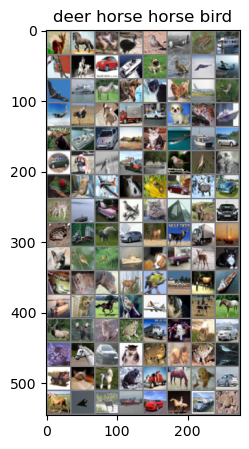

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

images, labels = next(iter(trainloader))
classes = trainset.classes
plt.figure(figsize=(10,5))
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0) / 2 + 0.5)
plt.title(' '.join(classes[label] for label in labels[:4]));
plt.show()
test_losses = []

In [4]:
class CIFAR10_NN(nn.Module):
    def __init__(self, activation_name, with_vg, with_bn):
        super(CIFAR10_NN, self).__init__()
        self.activation = activation_name
        self.with_vg = with_vg
        self.with_bn = with_bn
        self.fcLayer1 = nn.Linear(32*32*3, 512)
        self.fcLayer2 = nn.Linear(512, 256)
        self.fcLayer3 = nn.Linear(256, 128)
        
        # Fixing vanishing gradient
        if ( with_vg and with_bn ):
            self.fcbnLayer1 = nn.BatchNorm1d(128)
            self.fcbnLayer2 = nn.BatchNorm1d(64)
            self.fcbnLayer3 = nn.BatchNorm1d(32)
            self.fcbnLayer4 = nn.BatchNorm1d(16)
        
        self.fcLayer4 = nn.Linear(128, 64)
            
        self.fcLayer5 = nn.Linear(64, 32)
            
            
        self.fcLayer6 = nn.Linear(32, 16)
        self.fcLayervg1 = nn.Linear(16, 16)
        # Introduce Vanishing gradient by adding more layers
        if ( with_vg ):
            self.fcLayervg2 = nn.Linear(16, 16)
            self.fcLayervg3 = nn.Linear(16, 16)
            self.fcLayervg4 = nn.Linear(16, 16)
            self.fcLayervg5 = nn.Linear(16, 16)
            self.fcLayervg6 = nn.Linear(16, 16)
            self.fcLayervg7 = nn.Linear(16, 16)
            self.fcLayervg8 = nn.Linear(16, 16)
            self.fcLayervg9 = nn.Linear(16, 16)
        self.fcLayervg10 = nn.Linear(16, 16)
        # Fixing vanishing gradient
        if ( with_vg and with_bn ):
            self.initialize_weights()
        self.fcoLayer = nn.Linear(16, 10)
        if activation_name == "sigmoid": 
            self.activation = nn.Sigmoid()
        elif activation_name == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fcLayer1(x))
        x = self.activation(self.fcLayer2(x))
        x = self.activation(self.fcLayer3(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer1(x))
        x = self.activation(self.fcLayer4(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer2(x))
        x = self.activation(self.fcLayer5(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer3(x))
        x = self.activation(self.fcLayer6(x))
        # Introduce Vanishing gradient by adding more layers
        if ( self.with_vg ):
            x = self.activation(self.fcLayervg1(x))
            x = self.activation(self.fcLayervg2(x))
            x = self.activation(self.fcLayervg3(x))
            x = self.activation(self.fcLayervg4(x))
            x = self.activation(self.fcLayervg5(x))
            x = self.activation(self.fcLayervg6(x))
            x = self.activation(self.fcLayervg7(x))
            x = self.activation(self.fcLayervg8(x))
            x = self.activation(self.fcLayervg9(x)) 
            x = self.activation(self.fcLayervg10(x))
        
        # Fixing vanishing gradient
        if ( self.with_vg and self.with_bn ):
            x = self.activation(self.fcbnLayer4(x))
        x = self.fcoLayer(x)
        return x
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                if isinstance(self.activation, nn.ReLU):
                    nn.init.kaiming_normal_(m.weight)  # He initialization for relu activation
                else:
                    nn.init.xavier_normal_(m.weight)  # Xavier initialization for sigmoid and tanh activations
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

In [5]:
def train_and_test(activation, with_vg, with_bn):
    device = torch.device("cpu")
    model = CIFAR10_NN(activation, with_vg, with_bn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    epochs = 10
    train_losses = []
    test_losses = []
    gradient_logs = {}
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc=0.0
        with tqdm.tqdm(total=len(trainloader)) as pbar:
            for batch_idx, (images, labels) in enumerate(trainloader):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss=criterion(outputs, labels)
                loss.backward()
                running_loss += loss.item()
                last_loss = loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()), Accuracy='{0:.4f}'.format(float(train_acc.item()/(images.size(0)*(batch_idx+1)))))
                pbar.update(1)
                if batch_idx == len(trainloader) - 1:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {last_loss:.4f}")
                    check_gradients(model, gradient_logs, epoch)
                
                optimizer.step()
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss / len(testloader))
        average_loss = running_loss / len(trainloader)
        train_losses.append(average_loss)
        print(f"{epoch + 1} / {epochs}, activation = {activation}, loss = {average_loss: .4f}")
    return train_losses, test_losses, gradient_logs

In [6]:
def check_gradients(model, gradient_logs, epoch):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            if name not in gradient_logs:
                gradient_logs[name] = []
            if len(gradient_logs[name]) < epoch + 1:
                gradient_logs[name].append(grad_norm)
            else:
                gradient_logs[name][epoch] = grad_norm  # Ensure it logs per epoch

In [7]:
activation_fns = ["sigmoid", "tanh", "relu"]
with_vgs = [False, True] # Simulate vanishing gradient - true and false
with_bns = [False, True] # Fix simulated vanishing gradient by applying weight initialization and batch normalization - true and false
results = {}
for activation in activation_fns:
    for vg in with_vgs:
        for bn in with_bns:
            if not vg and bn: continue # Not necessary to do without vanishing gradient and with fix
            key = f"{activation}_vg{vg}_bn{bn}"
            results[key] = (train_and_test(activation, vg, bn))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 95.88it/s, Accuracy=0.2305, Loss=2.0891]


Epoch 1/10, Loss: 2.0891
1 / 10, activation = sigmoid, loss =  2.2160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.29it/s, Accuracy=0.3125, Loss=2.0487]


Epoch 2/10, Loss: 2.0487
2 / 10, activation = sigmoid, loss =  2.0440


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.83it/s, Accuracy=0.3490, Loss=1.9616]


Epoch 3/10, Loss: 1.9616
3 / 10, activation = sigmoid, loss =  1.9840


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 92.44it/s, Accuracy=0.3949, Loss=1.8857]


Epoch 4/10, Loss: 1.8857
4 / 10, activation = sigmoid, loss =  1.9367


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.12it/s, Accuracy=0.4328, Loss=1.8897]


Epoch 5/10, Loss: 1.8897
5 / 10, activation = sigmoid, loss =  1.8878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 94.19it/s, Accuracy=0.4496, Loss=1.8259]


Epoch 6/10, Loss: 1.8259
6 / 10, activation = sigmoid, loss =  1.8468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 94.60it/s, Accuracy=0.4712, Loss=1.8316]


Epoch 7/10, Loss: 1.8316
7 / 10, activation = sigmoid, loss =  1.8092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 94.59it/s, Accuracy=0.4884, Loss=1.9043]


Epoch 8/10, Loss: 1.9043
8 / 10, activation = sigmoid, loss =  1.7794


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 93.92it/s, Accuracy=0.5074, Loss=1.6303]


Epoch 9/10, Loss: 1.6303
9 / 10, activation = sigmoid, loss =  1.7504


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.84it/s, Accuracy=0.5442, Loss=1.5912]


Epoch 10/10, Loss: 1.5912
10 / 10, activation = sigmoid, loss =  1.6970


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.96it/s, Accuracy=0.1609, Loss=2.3006]


Epoch 1/10, Loss: 2.3006
1 / 10, activation = sigmoid, loss =  2.3041


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.81it/s, Accuracy=0.1551, Loss=2.2993]


Epoch 2/10, Loss: 2.2993
2 / 10, activation = sigmoid, loss =  2.3034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.01it/s, Accuracy=0.1614, Loss=2.3037]


Epoch 3/10, Loss: 2.3037
3 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.85it/s, Accuracy=0.1569, Loss=2.3027]


Epoch 4/10, Loss: 2.3027
4 / 10, activation = sigmoid, loss =  2.3034


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.45it/s, Accuracy=0.1583, Loss=2.3040]


Epoch 5/10, Loss: 2.3040
5 / 10, activation = sigmoid, loss =  2.3033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.54it/s, Accuracy=0.1570, Loss=2.3033]


Epoch 6/10, Loss: 2.3033
6 / 10, activation = sigmoid, loss =  2.3032


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.82it/s, Accuracy=0.1585, Loss=2.3001]


Epoch 7/10, Loss: 2.3001
7 / 10, activation = sigmoid, loss =  2.3033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.33it/s, Accuracy=0.1574, Loss=2.3050]


Epoch 8/10, Loss: 2.3050
8 / 10, activation = sigmoid, loss =  2.3033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.04it/s, Accuracy=0.1564, Loss=2.3019]


Epoch 9/10, Loss: 2.3019
9 / 10, activation = sigmoid, loss =  2.3033


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.45it/s, Accuracy=0.1588, Loss=2.2990]


Epoch 10/10, Loss: 2.2990
10 / 10, activation = sigmoid, loss =  2.3031


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.04it/s, Accuracy=0.2659, Loss=1.9977]


Epoch 1/10, Loss: 1.9977
1 / 10, activation = sigmoid, loss =  2.1388


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.40it/s, Accuracy=0.3233, Loss=2.0322]


Epoch 2/10, Loss: 2.0322
2 / 10, activation = sigmoid, loss =  1.9865


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.49it/s, Accuracy=0.3801, Loss=1.9026]


Epoch 3/10, Loss: 1.9026
3 / 10, activation = sigmoid, loss =  1.9259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.06it/s, Accuracy=0.4394, Loss=1.8465]


Epoch 4/10, Loss: 1.8465
4 / 10, activation = sigmoid, loss =  1.8761


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.12it/s, Accuracy=0.4784, Loss=1.9114]


Epoch 5/10, Loss: 1.9114
5 / 10, activation = sigmoid, loss =  1.8318


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.00it/s, Accuracy=0.5118, Loss=1.7451]


Epoch 6/10, Loss: 1.7451
6 / 10, activation = sigmoid, loss =  1.7986


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.20it/s, Accuracy=0.5387, Loss=1.7054]


Epoch 7/10, Loss: 1.7054
7 / 10, activation = sigmoid, loss =  1.7675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.58it/s, Accuracy=0.5656, Loss=1.6675]


Epoch 8/10, Loss: 1.6675
8 / 10, activation = sigmoid, loss =  1.7350


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.63it/s, Accuracy=0.5867, Loss=1.7080]


Epoch 9/10, Loss: 1.7080
9 / 10, activation = sigmoid, loss =  1.7073


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.06it/s, Accuracy=0.6057, Loss=1.7261]


Epoch 10/10, Loss: 1.7261
10 / 10, activation = sigmoid, loss =  1.6905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.51it/s, Accuracy=0.5047, Loss=1.9242]


Epoch 1/10, Loss: 1.9242
1 / 10, activation = tanh, loss =  1.9256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.35it/s, Accuracy=0.6230, Loss=1.8794]


Epoch 2/10, Loss: 1.8794
2 / 10, activation = tanh, loss =  1.7465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.80it/s, Accuracy=0.6773, Loss=1.5674]


Epoch 3/10, Loss: 1.5674
3 / 10, activation = tanh, loss =  1.6508


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 88.63it/s, Accuracy=0.7113, Loss=1.8372]


Epoch 4/10, Loss: 1.8372
4 / 10, activation = tanh, loss =  1.5837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 88.57it/s, Accuracy=0.7378, Loss=1.5882]


Epoch 5/10, Loss: 1.5882
5 / 10, activation = tanh, loss =  1.5324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.25it/s, Accuracy=0.7627, Loss=1.4438]


Epoch 6/10, Loss: 1.4438
6 / 10, activation = tanh, loss =  1.4878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.98it/s, Accuracy=0.7885, Loss=1.4681]


Epoch 7/10, Loss: 1.4681
7 / 10, activation = tanh, loss =  1.4452


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.71it/s, Accuracy=0.8128, Loss=1.4201]


Epoch 8/10, Loss: 1.4201
8 / 10, activation = tanh, loss =  1.4057


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.23it/s, Accuracy=0.8235, Loss=1.3960]


Epoch 9/10, Loss: 1.3960
9 / 10, activation = tanh, loss =  1.3732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.68it/s, Accuracy=0.8515, Loss=1.2128]


Epoch 10/10, Loss: 1.2128
10 / 10, activation = tanh, loss =  1.3293


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.50it/s, Accuracy=0.2516, Loss=2.2221]


Epoch 1/10, Loss: 2.2221
1 / 10, activation = tanh, loss =  2.2065


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.64it/s, Accuracy=0.2497, Loss=2.2547]


Epoch 2/10, Loss: 2.2547
2 / 10, activation = tanh, loss =  2.1967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.60it/s, Accuracy=0.2403, Loss=2.2014]


Epoch 3/10, Loss: 2.2014
3 / 10, activation = tanh, loss =  2.2179


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.51it/s, Accuracy=0.2379, Loss=2.2542]


Epoch 4/10, Loss: 2.2542
4 / 10, activation = tanh, loss =  2.2553


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.24it/s, Accuracy=0.2462, Loss=2.1540]


Epoch 5/10, Loss: 2.1540
5 / 10, activation = tanh, loss =  2.2208


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.85it/s, Accuracy=0.2656, Loss=2.1983]


Epoch 6/10, Loss: 2.1983
6 / 10, activation = tanh, loss =  2.1786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.90it/s, Accuracy=0.2694, Loss=2.2201]


Epoch 7/10, Loss: 2.2201
7 / 10, activation = tanh, loss =  2.1733


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.59it/s, Accuracy=0.2736, Loss=2.0845]


Epoch 8/10, Loss: 2.0845
8 / 10, activation = tanh, loss =  2.1704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.87it/s, Accuracy=0.2657, Loss=2.1570]


Epoch 9/10, Loss: 2.1570
9 / 10, activation = tanh, loss =  2.1776


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.39it/s, Accuracy=0.2513, Loss=2.2389]


Epoch 10/10, Loss: 2.2389
10 / 10, activation = tanh, loss =  2.2153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.81it/s, Accuracy=0.4941, Loss=1.7627]


Epoch 1/10, Loss: 1.7627
1 / 10, activation = tanh, loss =  1.9417


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.38it/s, Accuracy=0.5846, Loss=1.7124]


Epoch 2/10, Loss: 1.7124
2 / 10, activation = tanh, loss =  1.7935


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.50it/s, Accuracy=0.6207, Loss=1.6365]


Epoch 3/10, Loss: 1.6365
3 / 10, activation = tanh, loss =  1.7310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.52it/s, Accuracy=0.6456, Loss=1.7322]


Epoch 4/10, Loss: 1.7322
4 / 10, activation = tanh, loss =  1.6892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.23it/s, Accuracy=0.6693, Loss=1.6697]


Epoch 5/10, Loss: 1.6697
5 / 10, activation = tanh, loss =  1.6507


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.72it/s, Accuracy=0.6892, Loss=1.6799]


Epoch 6/10, Loss: 1.6799
6 / 10, activation = tanh, loss =  1.6149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.63it/s, Accuracy=0.7051, Loss=1.7146]


Epoch 7/10, Loss: 1.7146
7 / 10, activation = tanh, loss =  1.5857


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.59it/s, Accuracy=0.7203, Loss=1.6428]


Epoch 8/10, Loss: 1.6428
8 / 10, activation = tanh, loss =  1.5594


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 82.61it/s, Accuracy=0.7395, Loss=1.5505]


Epoch 9/10, Loss: 1.5505
9 / 10, activation = tanh, loss =  1.5317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 81.54it/s, Accuracy=0.7502, Loss=1.4941]


Epoch 10/10, Loss: 1.4941
10 / 10, activation = tanh, loss =  1.5118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.12it/s, Accuracy=0.5720, Loss=1.5888]


Epoch 1/10, Loss: 1.5888
1 / 10, activation = relu, loss =  1.7917


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.55it/s, Accuracy=0.7340, Loss=1.2457]


Epoch 2/10, Loss: 1.2457
2 / 10, activation = relu, loss =  1.5242


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 86.38it/s, Accuracy=0.8090, Loss=1.3153]


Epoch 3/10, Loss: 1.3153
3 / 10, activation = relu, loss =  1.3908


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.52it/s, Accuracy=0.8664, Loss=1.5720]


Epoch 4/10, Loss: 1.5720
4 / 10, activation = relu, loss =  1.2943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.50it/s, Accuracy=0.9210, Loss=1.5328]


Epoch 5/10, Loss: 1.5328
5 / 10, activation = relu, loss =  1.2077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.70it/s, Accuracy=0.9621, Loss=1.2004]


Epoch 6/10, Loss: 1.2004
6 / 10, activation = relu, loss =  1.1335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.38it/s, Accuracy=1.0031, Loss=0.9472]


Epoch 7/10, Loss: 0.9472
7 / 10, activation = relu, loss =  1.0609


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 85.42it/s, Accuracy=1.0437, Loss=0.8440]


Epoch 8/10, Loss: 0.8440
8 / 10, activation = relu, loss =  0.9848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 84.85it/s, Accuracy=1.0771, Loss=1.1057]


Epoch 9/10, Loss: 1.1057
9 / 10, activation = relu, loss =  0.9236


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 87.69it/s, Accuracy=1.1191, Loss=0.7960]


Epoch 10/10, Loss: 0.7960
10 / 10, activation = relu, loss =  0.8498


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.86it/s, Accuracy=0.2491, Loss=2.1178]


Epoch 1/10, Loss: 2.1178
1 / 10, activation = relu, loss =  2.1560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 83.63it/s, Accuracy=0.3612, Loss=1.8795]


Epoch 2/10, Loss: 1.8795
2 / 10, activation = relu, loss =  1.9443


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 80.83it/s, Accuracy=0.4339, Loss=1.8332]


Epoch 3/10, Loss: 1.8332
3 / 10, activation = relu, loss =  1.8573


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.84it/s, Accuracy=0.5453, Loss=1.5592]


Epoch 4/10, Loss: 1.5592
4 / 10, activation = relu, loss =  1.7072


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.34it/s, Accuracy=0.6121, Loss=1.6411]


Epoch 5/10, Loss: 1.6411
5 / 10, activation = relu, loss =  1.6260


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.14it/s, Accuracy=0.6691, Loss=1.5529]


Epoch 6/10, Loss: 1.5529
6 / 10, activation = relu, loss =  1.5453


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.58it/s, Accuracy=0.7205, Loss=1.6669]


Epoch 7/10, Loss: 1.6669
7 / 10, activation = relu, loss =  1.4809


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 73.97it/s, Accuracy=0.7623, Loss=1.5732]


Epoch 8/10, Loss: 1.5732
8 / 10, activation = relu, loss =  1.4158


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 73.54it/s, Accuracy=0.8008, Loss=1.2535]


Epoch 9/10, Loss: 1.2535
9 / 10, activation = relu, loss =  1.3501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 69.25it/s, Accuracy=0.8388, Loss=1.3952]


Epoch 10/10, Loss: 1.3952
10 / 10, activation = relu, loss =  1.2948


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 73.11it/s, Accuracy=0.3506, Loss=1.9117]


Epoch 1/10, Loss: 1.9117
1 / 10, activation = relu, loss =  2.1112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:06<00:00, 62.52it/s, Accuracy=0.4781, Loss=1.6839]


Epoch 2/10, Loss: 1.6839
2 / 10, activation = relu, loss =  1.8540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 74.11it/s, Accuracy=0.5535, Loss=1.6795]


Epoch 3/10, Loss: 1.6795
3 / 10, activation = relu, loss =  1.7394


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 76.96it/s, Accuracy=0.6132, Loss=1.6340]


Epoch 4/10, Loss: 1.6340
4 / 10, activation = relu, loss =  1.6689


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.82it/s, Accuracy=0.6770, Loss=1.6087]


Epoch 5/10, Loss: 1.6087
5 / 10, activation = relu, loss =  1.5788


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.71it/s, Accuracy=0.7253, Loss=1.3159]


Epoch 6/10, Loss: 1.3159
6 / 10, activation = relu, loss =  1.5106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.59it/s, Accuracy=0.7490, Loss=1.2662]


Epoch 7/10, Loss: 1.2662
7 / 10, activation = relu, loss =  1.4770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 78.51it/s, Accuracy=0.7825, Loss=1.3289]


Epoch 8/10, Loss: 1.3289
8 / 10, activation = relu, loss =  1.4310


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 79.62it/s, Accuracy=0.8191, Loss=1.3888]


Epoch 9/10, Loss: 1.3888
9 / 10, activation = relu, loss =  1.3665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 77.88it/s, Accuracy=0.8456, Loss=1.3146]


Epoch 10/10, Loss: 1.3146
10 / 10, activation = relu, loss =  1.3311


[2.21604994556788, 2.043995385279741, 1.9839537442492707, 1.9367034785887773, 1.8877508652484631, 1.8468240005585848, 1.8092026329406388, 1.7793566073907916, 1.750398685560202, 1.6969728448506816] [2.091145141215264, 2.004845830458629, 1.964966408814056, 1.9243738183492347, 1.8909581975091863, 1.894527121435238, 1.8555424817000763, 1.8620900926710684, 1.829126078871232, 1.7711938121650792]


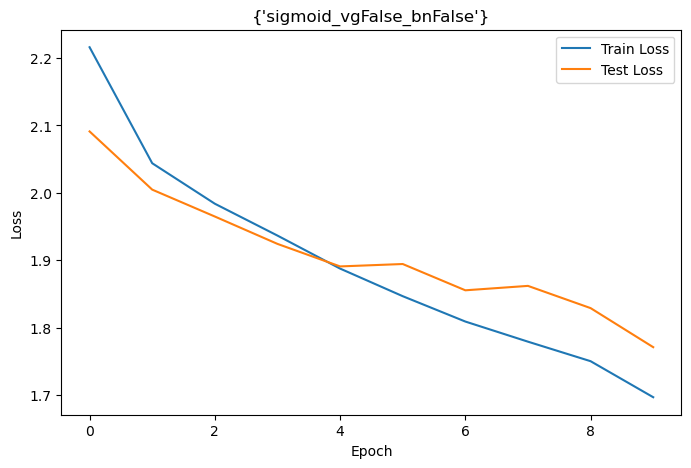

[2.3040856168703043, 2.303367211080878, 2.3032272435210244, 2.303392341374741, 2.3032522884476214, 2.3031513111670607, 2.303332303795973, 2.303306639956696, 2.303262178855174, 2.303134306007639] [2.3030181745939617, 2.3028427407711365, 2.302916614315178, 2.3034241320211675, 2.30267628235153, 2.303152733211276, 2.303249283681942, 2.303023108953162, 2.302823712554159, 2.3029238906087754]


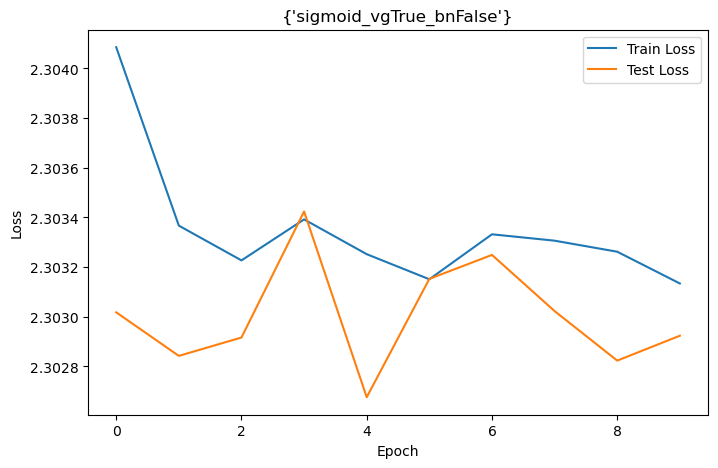

[2.138758454481354, 1.986465521480726, 1.9258524749590002, 1.876109911352777, 1.8318014120506814, 1.798640414881889, 1.7674799425827572, 1.7350461729957014, 1.7072553613301737, 1.6904573586895644] [2.217540562907352, 1.951337547241887, 1.918991416315489, 1.8729716856268388, 1.8609572860259045, 1.831897488123254, 1.8489779701715783, 1.8109634088564524, 1.80394413954095, 1.7710552743718595]


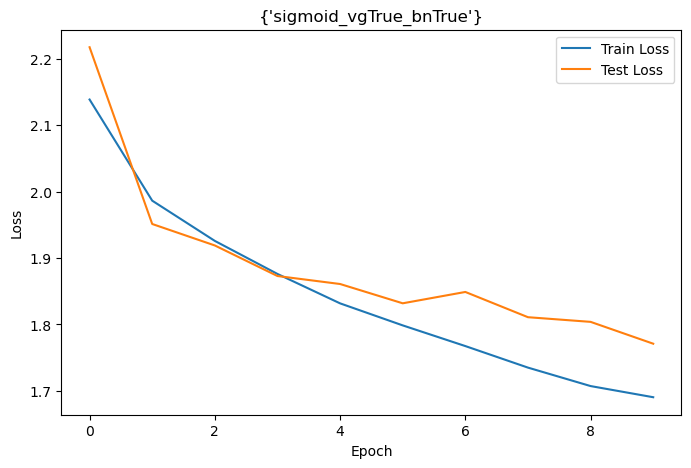

[1.9256208747854013, 1.746485915330365, 1.6508171168129768, 1.583707352123602, 1.532382852281146, 1.4878060119536223, 1.445156099546291, 1.4056660638136023, 1.3731889319236932, 1.3293166578273334] [1.7979793548583984, 1.7192511603802065, 1.6398703735085982, 1.6029275550117976, 1.5867803640003446, 1.5455613257009773, 1.5584611771981927, 1.528451620777951, 1.531375925752181, 1.5329208585280407]


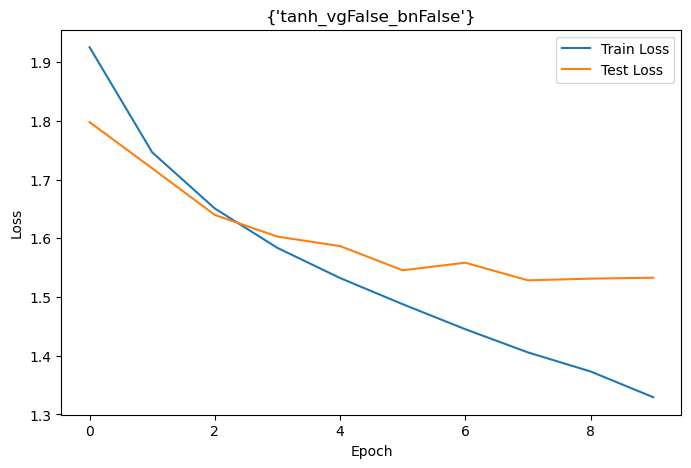

[2.206548914580089, 2.196740244965419, 2.217874539172863, 2.2552828849733944, 2.2207636790507284, 2.178571313848276, 2.1732695864899383, 2.1703568419532093, 2.177621776185682, 2.215313545578276] [2.192118958581852, 2.261030133766464, 2.2219029559364802, 2.2724747295621075, 2.184465347966061, 2.1720558963244474, 2.179379761973514, 2.1581084848959233, 2.1541743308682983, 2.1670617664916607]


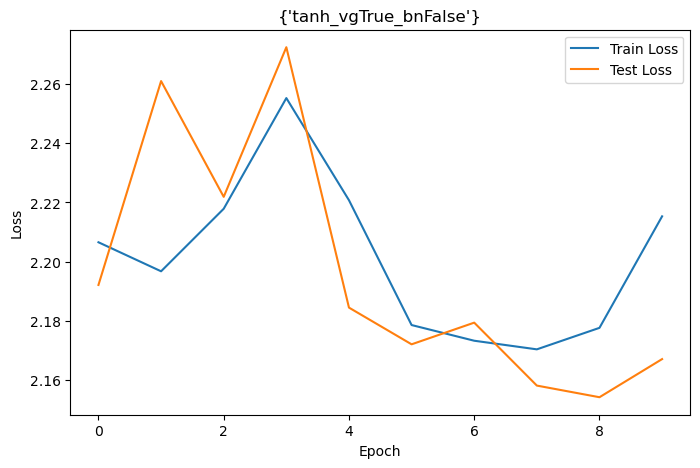

[1.9417484718210556, 1.7935358560298715, 1.731025006460107, 1.6892139237859976, 1.6507271156286645, 1.6148839832266884, 1.5857390351307667, 1.5593724439820975, 1.5316706112278697, 1.5118442642719239] [1.8123204738278933, 1.7534694611271726, 1.7051304699499397, 1.7074307595627218, 1.6733484479445446, 1.637652523909943, 1.6303707119784778, 1.6241382149201404, 1.6068049488188345, 1.5904150371310077]


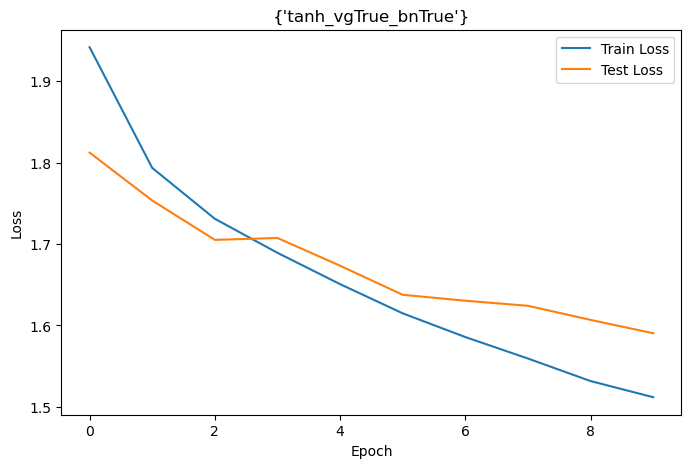

[1.7916854318145596, 1.5242302963495864, 1.3908334946083596, 1.2942831001013442, 1.2077180237111533, 1.133533054757911, 1.0608687580698897, 0.9848190565853168, 0.923642152410639, 0.8498329105584518] [1.5770534548578383, 1.487734841395028, 1.3922633098650583, 1.3796212974982927, 1.3454542763625519, 1.3401542373850375, 1.3401421300972565, 1.3680901799020888, 1.3651798058159743, 1.3969594723061671]


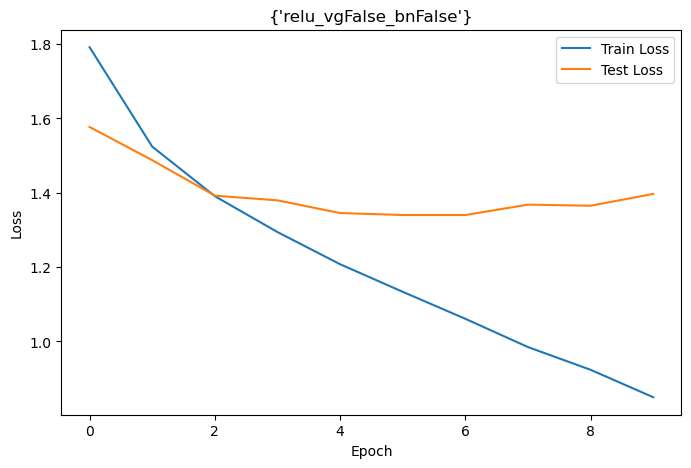

[2.1560283323078204, 1.9442571072322328, 1.857325309072919, 1.7072217001024719, 1.626030197533805, 1.545282942559713, 1.4808706191494643, 1.4157769356847114, 1.350128920791704, 1.2947838147887794] [1.9790493355521672, 1.929369638237772, 1.7804717323448085, 1.6886430390273468, 1.63894328437274, 1.5901322877859767, 1.5639180729660807, 1.5516741019261033, 1.5517611503601074, 1.5155757409107835]


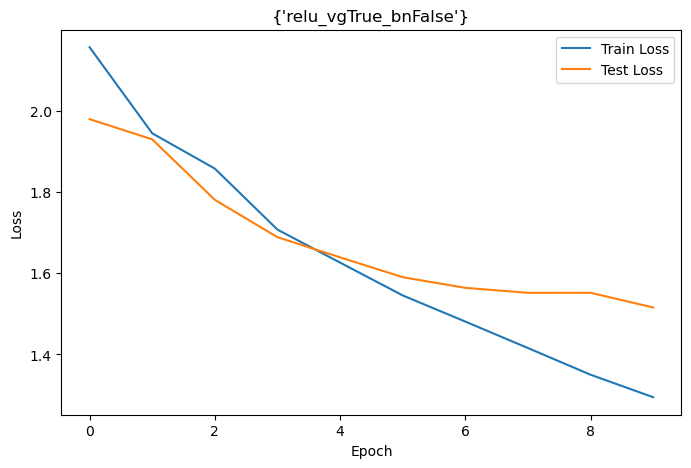

[2.111247893794418, 1.8539540499372555, 1.7393589007580066, 1.6689252167406594, 1.5787765555979345, 1.51059849091503, 1.4770293790666038, 1.431021013528185, 1.3664642041906372, 1.3311416526584674] [1.9419789736783957, 1.7820417020894304, 1.7186159846148914, 1.6812685290469398, 1.565594581109059, 1.545966546746749, 1.5205927830708177, 1.5037286673920065, 1.4703584411476232, 1.4279240716861774]


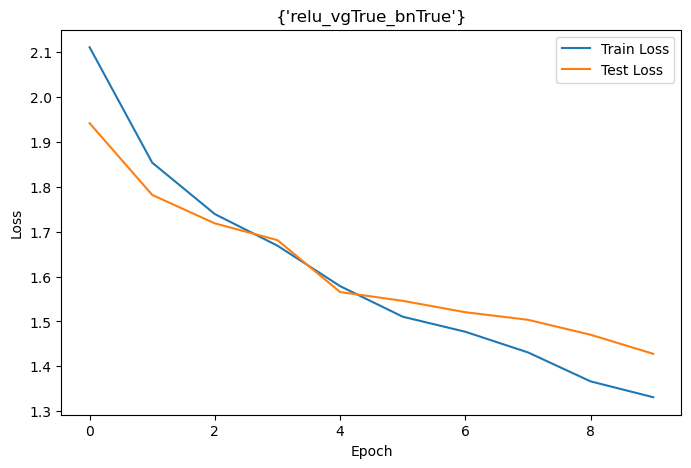

In [8]:
# Plotting results for train and test loss
for name, result in results.items():
    print(result[0], result[1])
    plt.figure(figsize=(8, 5))
    plt.plot(result[0], label = 'Train Loss')
    plt.plot(result[1], label = 'Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title({name})
    plt.legend()
    plt.show()

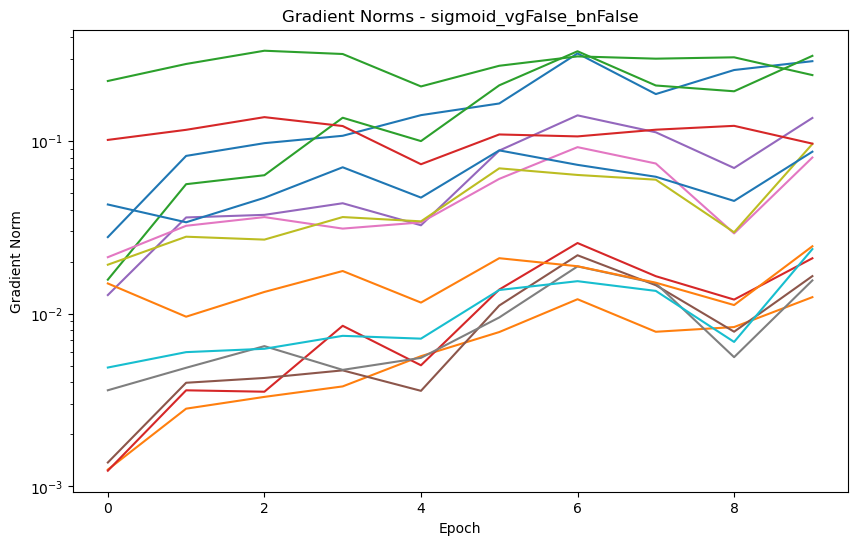

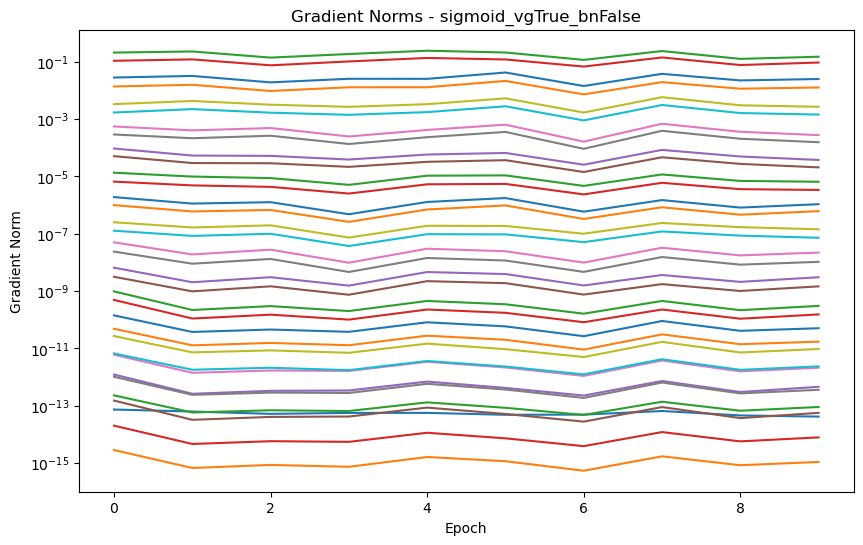

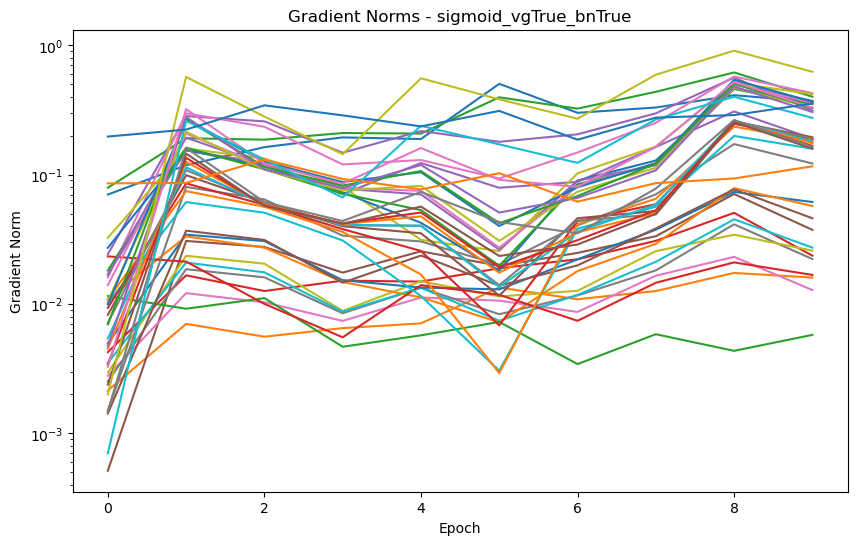

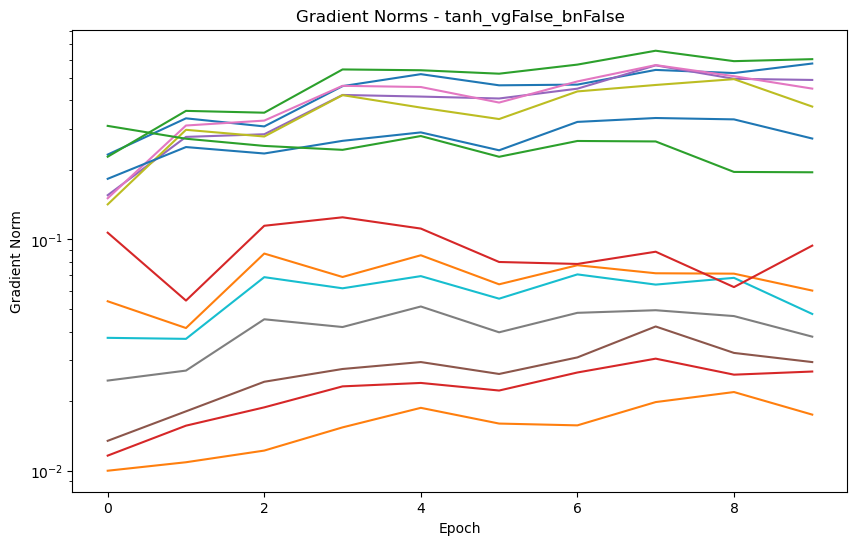

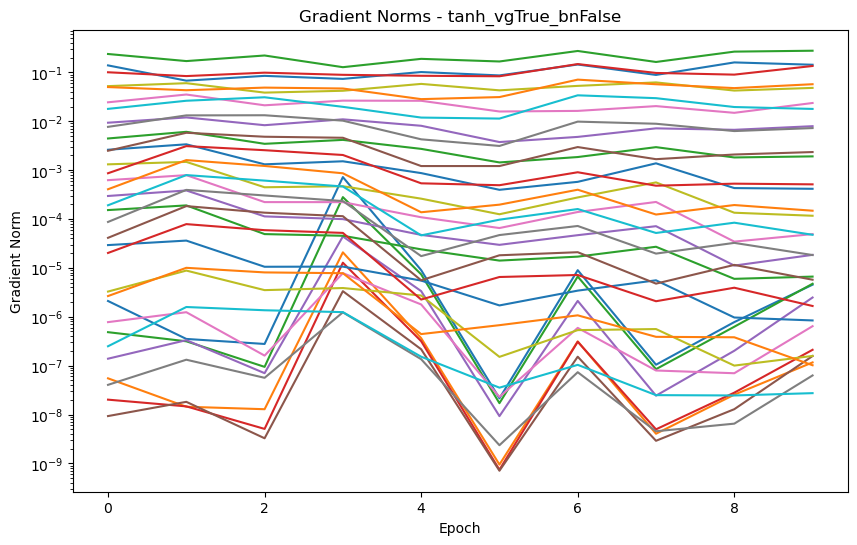

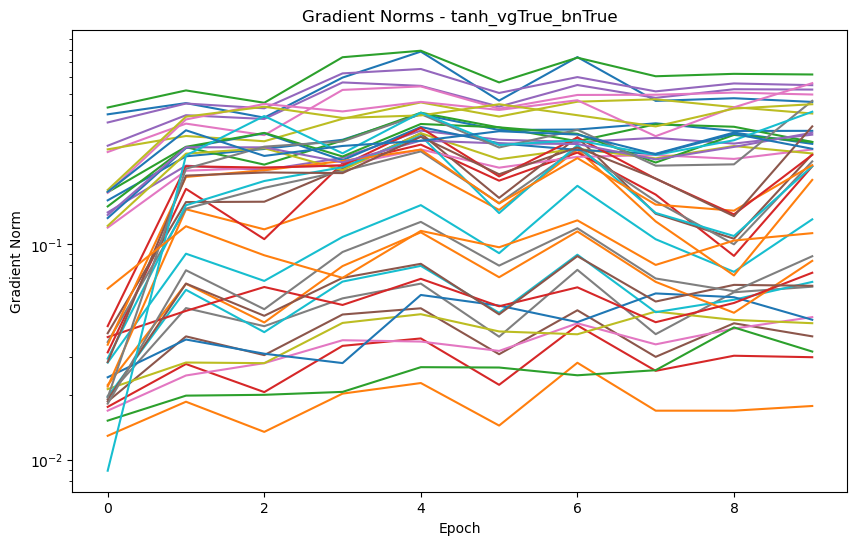

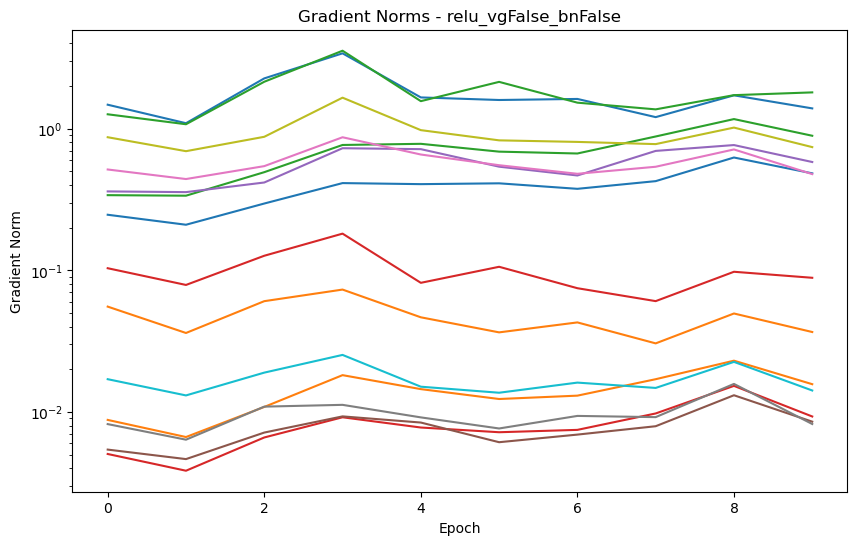

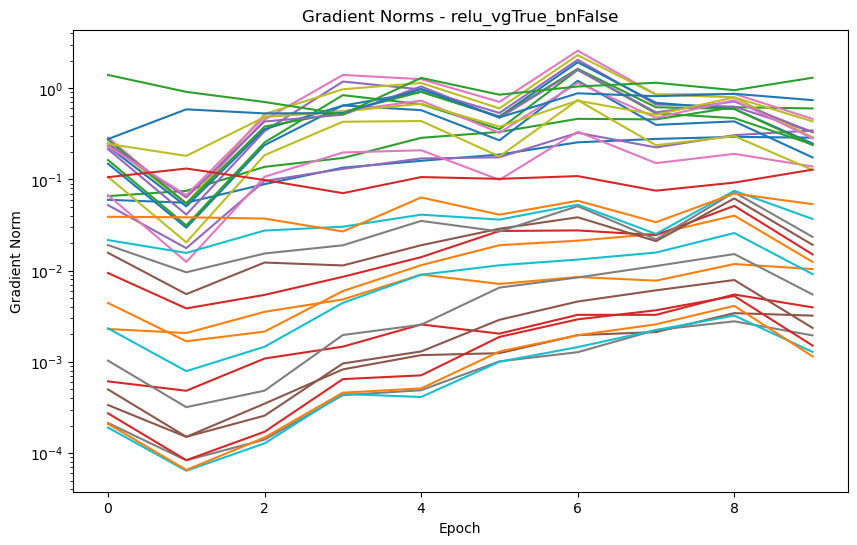

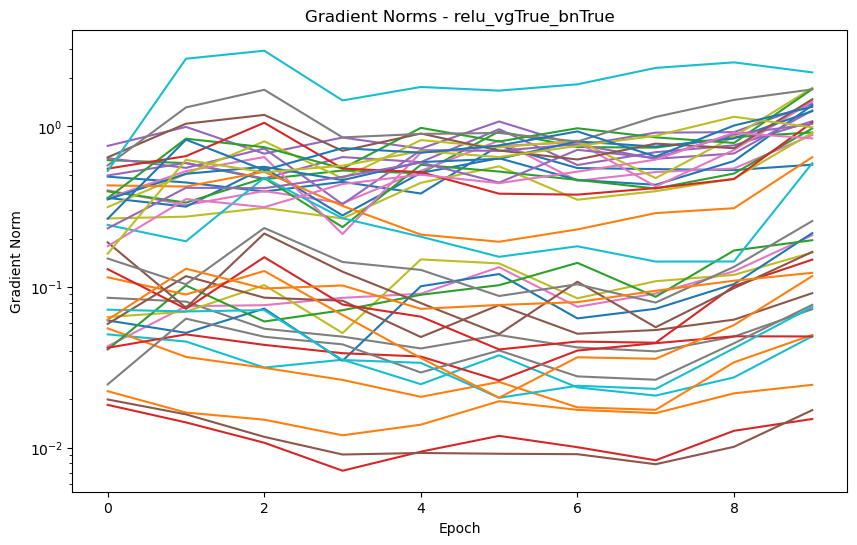

In [9]:
# Plotting gradients to show the effects of vanishing gradient and weight initialization
for name, result in results.items():
    _, _, gradient_logs = result  # Unpack the gradient logs
    plt.figure(figsize=(10, 6))
    for layer, norms in gradient_logs.items():
        plt.plot(norms, label=layer)
    plt.xlabel("Epoch")
    plt.ylabel("Gradient Norm")
    plt.yscale("log")
    plt.title(f"Gradient Norms - {name}")  # Add title with details
    # plt.legend()
    plt.show()